[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/prokaj/elte-python/blob/main/12-gyakorlat.ipynb)

In [17]:
def on_colab():
    import sys
    return 'google.colab' in sys.modules


def on_vscode():
    import os
    return 'VSCODE_PID' in os.environ


# Házi feladat

## Intervallum felezés vs. Newton--Raphson

Egy pozitív egész szám négyzetgyöke alatt értsük
  azt a legnagyobb egész számot aminek a négyzete nem nagyobb az adott
  számnál. Írjuk meg az ezt számoló függvényt két algoritmus
  alkalmazásával is. Az egyik az intervallum felezés, a másik a Newton
  iteráció módosítása. Valós számokra  a Newton algoritmus a következő
  lenne:
  $$
  x_{n+1} = \frac{x_n^2+a}{2x_n}, \quad x_0=a.
  $$
  Ezt szeretnénk úgy módosítani, hogy csak egész számok műveleteit
  használjuk és véges sok lépés után eljusson a fenti értelemben
  négyzetgyökhöz.
  

  Hasonlítsuk össze a két algoritmust az elvégzett számolási lépések
  alapján! Hogyan függ a lépések száma $a$-tól?
  Mérjük meg a futási időket is! Az eredményekből készítsünk
  ábrát!

  Végül is melyik a gyorsabb módszer?


In [1]:
def newton_root(n, cond=lambda: True):
    if n<0:
        raise ValueError
    if n==0:
        return 0
    x = n
    y = n//x
    while (y < x) and cond():
        x = (x+y) >> 1
        y = n//x
    return x
    

def bisect_root(n, cond=lambda: True):
    a, b = 0, n+1
    
    while b>a+1  and cond():
        c = (a + b)>>1
        if c*c>n:
            b = c 
        else:
            a = c
    return a
    

In [3]:
try:
    import ipytest
    ipytest.autoconfig()
    
except ModuleNotFoundError:
    ! pip install ipytest

In [4]:
%%ipytest

def test_root():
    for n in range(10000):
        k = newton_root(n)
        assert type(k) is int
        assert k*k <= n < (k+1)*(k+1)

        k = bisect_root(n)
        assert type(k) is int
        assert k*k <= n < (k+1)*(k+1)

    for e in range(100):
        n = 193 + 29**(e*10)
        assert bisect_root(n)==newton_root(n)

.                                                                                            [100%]
1 passed in 2.09s


Lépésszámok.

In [5]:
from functools import wraps
class Count:    
    def __init__(self):
        self.cnt = 0

    def __call__(self):
        self.cnt += 1
        return True

    def reset(self):
        self.cnt = 0

def count_steps(f):
    cnt = Count()
    @wraps(f)
    def _f(n):
        cnt.reset()
        f(n, cnt)
        return cnt.cnt
    return _f


In [6]:
import math
exponents = [math.log(37)*(e*10) for e in range(200)]
n_values = [239 + 37**(e*10) for e in range(200)]


newton_count_steps = count_steps(newton_root)
newton_steps = [newton_count_steps(n) for n in n_values]

bisect_count_steps = count_steps(bisect_root)
bisect_steps = [bisect_count_steps(n) for n in n_values]

In [7]:
import matplotlib.pyplot as plt

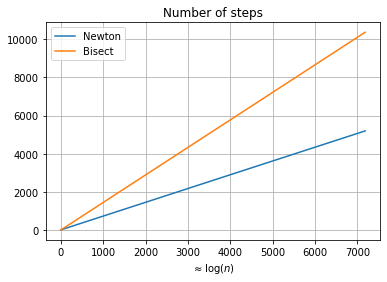

In [8]:
plt.plot(exponents, newton_steps, label="Newton")
plt.plot(exponents, bisect_steps, label="Bisect")
plt.grid()
plt.legend()
# plt.xscale('log')
plt.xlabel('$\\approx \\log(n)$')
plt.title('Number of steps')
plt.show()


Futási idők.

In [9]:
import time

def timeit(f, n, repeat=10):
    start = time.time()
    for _ in range(repeat):
        f(n)
    t = time.time()-start
    return t/repeat

import math
log2_exponents = [math.log(37)*(e*10)/math.log(2) for e in range(100)]
n_values = [239 + 37**(e*10) for e in range(100)]

newton_times = [timeit(newton_root, n) for n in n_values]
bisect_times = [timeit(bisect_root, n) for n in n_values]
    


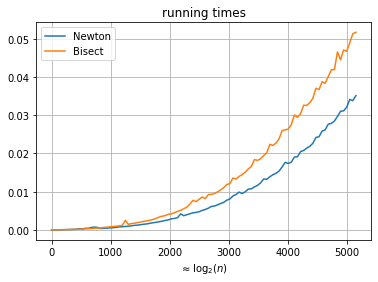

In [11]:
plt.plot(log2_exponents, newton_times, label="Newton")
plt.plot(log2_exponents, bisect_times, label="Bisect")
plt.grid()
plt.legend()
# plt.xscale('log')
plt.xlabel('$\\approx \\log_2(n)$')
plt.title('running times')
plt.show()


# Sudoku solver

Ez egy [project Euler](https://projecteuler.net/problem=96) feladat. A teszt adatok is onnan vannak:

https://projecteuler.net/project/resources/p096_sudoku.txt

In [12]:
import urllib


url = "https://projecteuler.net/project/resources/p096_sudoku.txt"

urllib.request.urlretrieve(url, "sudoku.txt")


('sudoku.txt', <http.client.HTTPMessage at 0x7ff92e8f1a10>)

In [13]:
! head sudoku.txt

Grid 01
003020600
900305001
001806400
008102900
700000008
006708200
002609500
800203009
005010300


In [14]:
class Sudoku:
    
    def __init__(self, grid, name=None):
        self.grid = grid
        self.name = name

    @classmethod
    def from_file(cls, f):
        name = f.readline().strip()
        grid = [[cls.value(x) for x in f.readline().strip()] for i in range(9)]
        if any(len(line)!=9 for line in grid):
            raise ValueError
        return cls(grid, name)
    
    @staticmethod
    def value(x):
        if x=='_':
            return 0
        return int(x)

    def __str__(self):
        return f'{self.name}:\n{self.txt}'
    
    def _repr_html_(self):
        return html_table(self.grid, self.name)
    
    def copy(self):
        grid = [line.copy() for line in self.grid]
        return type(self)(grid, self.name)

    def txt(self):
        symbols='_123456789'
        grid = '\n'.join(''.join(symbols[x] for x in line) for line in self.grid)
        return grid
    
    


In [15]:
s_table_jupyter = """
<div id="{div_id}">
<style>

    div#{div_id} table#{tid}  {{
        border-collapse: collapse;
        border: 1px solid black;
    }}

    div#{div_id} table#{tid} td {{
        text-align: center;
        vertical-align: middle;
        height: 2em;
        width: 2em;
        border: 1px solid black;
    }}

    
    div#{div_id} table#{tid} tr:nth-child(3) {{
        border-bottom: 2px solid black;
    }}

    div#{div_id} table#{tid} tr:nth-child(6) {{
        border-bottom: 2px solid black;
    }}
    

    div#{div_id} table#{tid} colgroup#mid-colgroup {{
        border-left: 2px solid black;
        border-right: 2px solid black;
    }}
</style>
<table id="{tid}">
<colgroup span="3"></colgroup>
<colgroup id="mid-colgroup" span="3"></colgroup>
<caption>{name}</caption>
{table}
</table>
</div>
"""

s_table_vs = """
<div id="{div_id}">
<style>
    

    div#{div_id} table#{tid}  {{
        border-collapse: separate;
        border-spacing: 2px;
        background: #ffffff;
        width: auto;
    }}

    div#{div_id} table#{tid} td {{
        text-align: center;
        vertical-align: middle;
        color: #303030;
        background: #d0d0d0;
        height: 2em;
        width: 2em;
        display: table-cell;
    }}

    div#{div_id} tr#table-row-3,
    div#{div_id} tr#table-row-6 {{
        border-spacing: 2px;
    }}
    
</style>
<table id="{tid}">
<colgroup span="3"></colgroup>
<colgroup id="mid-colgroup" span="3"></colgroup>
<caption>{name}</caption>
<tbody>
{table}
</tbody>
</table>
</div>
"""


In [18]:
import uuid

s_table = s_table_vs if on_vscode() else s_table_jupyter

def table_cell(value):
    if value==0:
        value = ''
    return f'<td>{value}</td>'

def table_row(row, i=0):
    row = ''.join(map(table_cell, row))
    return f'<tr id="table-row-{i}">{row}</tr>'

def html_table(grid, name):
    grid = '\n'.join(table_row(line, i) for i, line in enumerate(grid, 1))
    tid = f"table-{uuid.uuid1()}"
    div_id = f"output-{uuid.uuid1()}"
    return s_table.format(div_id=div_id, tid=tid, table=grid, name=name)
    

In [19]:
with open('sudoku.txt') as f:
    sudoku = Sudoku.from_file(f)

In [20]:
sudoku

,,3,,2,,6,,
9,,,3,,5,,,1
,,1,8,,6,4,,
,,8,1,,2,9,,
7,,,,,,,,8
,,6,7,,8,2,,
,,2,6,,9,5,,
8,,,2,,3,,,9
,,5,,1,,3,,


## Mi a feladat?



A Sudokuban ki kell tölteni a hiányzó mezőket úgy, hogy minden sor, oszlop és a 9 db 3x3-as négyzet mindegyike tartalmazza az összes számot egytől kilencig.

Minden oszlop, sor és kis négyzet kilenc követelményt jelent nevezetesen azt, hogy az adott tábla részen kell, hogy legyen $1,...,9$.
Ez összesen $3*9*9$ követelmény. További követlemény, hogy minden mező pontosan egy értéket tartalmazhat. Ez további 81 követelmény, így összesen $4*9*9$
követelmény van.

Minden cellába írhatjuk a 9 szám bármelyikét ez összesen $9*9*9$ opció. 

Minden opció ki tud elégíteni néhány követelményt, pl. ha az opció az hogy (1,1) mezőben 2 van, akkor ha ezt az opciót kiválasztjuk, azzal teljesülni fog,
hogy az első sorban, első oszlopban és az (1,1) tartalmazó 3x3-as négyzetben is van 2-es.

A feladványt, akkor oldottuk meg, ha kiválasztottuk az opciók egy részét úgy, hogy minden követelményt pontosan egy opció teljesít a kiválasztottak közül. 


Kicsit messzebről ránézve, van egy páros gráfunk. A csúcsok egyik csoportja a követelményekből, a másik az opciókból áll. Egy követelmény és egy opció között akkor megy él, ha az adott opció kiválasztásával kielégítjük a követelményt.

A cél élek egy részének kiválasztása úgy, hogy minden követleményből pontosan egy él induljon ki. Ha ezt sikerült elérni, a kiválasztott élek opció végpontjai egy kitöltését adják a játékmezőnek.

A megoldás megtalálása elméletben egyszerű. 

1. Válasszunk egy `c` követelményt.
2. Válasszunk hozzá egy `r` opciót, ami `c`-t kielégíti.
3. Töröljük az összes olyan követelményt, amit `r` kielégít. 
4. Töröljük az összes olyan opciót, ami a törölt követelmények bármelyikét kielégíti kivéve `r`-et.
5. Folytassuk a kisebb gráffal, amíg el nem fogynak a követelmények.

Lehet, hogy kóddal leírva könnyebben érthető.

```
def search(G):
    req = G.first_req
    while req.neighbors:
        option = reg.neighbors.first_option
        solution = search(new_graph(G, option))
        if solution is not None:
            return (option,) + solution
        remove(G, option)
    return None
```

Itt `new_graph(G, r)` visszaadja a gráfot amit úgy kapunk, hogy 
`option` által kielégített követelményeket  és azokat az opciókat amik `option`-nal összeegyeztethetlenek elhagyjuk.

Azt feltételezzük, hogy a `new_graph` függvény nem módosítja `G`-t a visszaadott gráf másolat. 

A `remove` függvény a gráfból eltávolítja az `option` csúcsot.

A másik lehetőség, hogy a módosítást a search hívása után visszaállítjuk.

A futási idő attól függ, hogyan választjuk ki követelményt. A legegyszerűbb módszer: vegyük azt amihez aktuálisan a legkevesebb opció tartozik.
Ez pont annak felel meg, amit a játék során magunk is csinálnánk, pl ha egy mezőbe csak egy lehetőség maradt az kitöltjük. 

In [21]:
from itertools import product

def subsquare(i, j):
    return (i//3)*3 + j//3

def idx2code(n):
    n, val = divmod(n, 9)
    i, j = divmod(n, 9)
    return i, j, val

def code2idx(a, b, c):
    return a*81+b*9+c 

def satisfies(option_id, requirement_id):
    i, j, val0 = idx2code(option_id)
    t, k, val1 = idx2code(requirement_id)
    return (
        (t==3 and i==k and j==val1) or 
        (
            (val0==val1) and 
            (
                (t == 0 and i==k) or
                (t == 1 and j==k) or
                (t == 2 and subsquare(i,j) == k)
            ) 
        )
    )


class Requirement:    

    def __init__(self, idx):
        self.idx = idx
        self.neighbors = set()
    
    def __repr__(self):
        return f"{type(self).__name__}({self.idx})"

    def __str__(self):
        t, k, val = idx2code(self.idx)
        if t==3:
            return f"There must be something at ({k+1}, {val+1})"
        if t==0:
            position = f'{k+1}th row'
        elif t==1:
            position = f'{k+1}th column'
        else:
            i, j = divmod(k, 3)
            position = f'({i+1}, {j+1}) sub square'
        return f"There must be a {val+1} in the {position}"

    def is_neighbor(self, option):
        return satisfies(option, self.idx)
    
    def remove(self, to_remove):
        res = type(self)(self.idx)
        res.neighbors = self.neighbors.difference(to_remove)
        return res

    
class Option(int):
    def __str__(self):
        i, j, val = idx2code(self)
        return f"{val+1} at ({i+1}, {j+1})"


def get_options(self):
    grid = self.grid
    for i, line in enumerate(grid):
        for j, x in enumerate(line):
            if x==0:
                for val in range(9):
                    yield Option(code2idx(i, j, val))
            else:
                yield Option(code2idx(i, j, x-1))

Sudoku.options = get_options


In [22]:
options = list(sudoku.options())

In [25]:
print(*options[:20], sep="\n")

1 at (1, 1)
2 at (1, 1)
3 at (1, 1)
4 at (1, 1)
5 at (1, 1)
6 at (1, 1)
7 at (1, 1)
8 at (1, 1)
9 at (1, 1)
1 at (1, 2)
2 at (1, 2)
3 at (1, 2)
4 at (1, 2)
5 at (1, 2)
6 at (1, 2)
7 at (1, 2)
8 at (1, 2)
9 at (1, 2)
3 at (1, 3)
1 at (1, 4)


In [26]:
requirements = [Requirement(x) for x in range(4*9*9)]
len(requirements), len(options)

(324, 473)

In [27]:
o = options[10]
r = requirements[81+9]
print(f'option:\t\t\t\t{o}\nrequirement:\t\t\t{r}\noption satisfies requirement:\t{r.is_neighbor(o)}')

option:				2 at (1, 2)
requirement:			There must be a 1 in the 2th column
option satisfies requirement:	False


In [28]:
for o, r in product(options, requirements):
    if r.is_neighbor(o):
        r.neighbors.add(o)

In [31]:
[str(x) for x in requirements[0].neighbors]

['1 at (1, 1)',
 '1 at (1, 9)',
 '1 at (1, 2)',
 '1 at (1, 6)',
 '1 at (1, 4)',
 '1 at (1, 8)']

In [ ]:
min?

Docstring:
min(iterable, *[, default=obj, key=func]) -> value
min(arg1, arg2, *args, *[, key=func]) -> value

With a single iterable argument, return its smallest item. The
default keyword-only argument specifies an object to return if
the provided iterable is empty.
With two or more arguments, return the smallest argument.
Type:      builtin_function_or_method


In [33]:
import logging
logger = logging.getLogger('sudoku')
logging.basicConfig()
logger.setLevel(logging.WARNING)


In [32]:

def search(G):
    if len(G)==0:
        return tuple()

    req = min(G, key=lambda x: len(x.neighbors))
    logger.info('%s', req)

    while len(req.neighbors)>0:

        option = next(iter(req.neighbors))
        logger.info('trying %s', option)
        
        # logger.info(f'trying {option}')
        solution = search(remove(G, option))
        
        if solution is not None:
            logger.info('%s works', option)
            return (option,) + solution
        
        logger.info('%s rejected', option)
        for r in G:
            r.neighbors.discard(option)

def remove(G, opt):
    to_remove = set.union(*(r.neighbors for r in G if opt in r.neighbors))
    to_remove.discard(opt)
    return [r.remove(to_remove) for r in G if opt not in r.neighbors]


In [ ]:
# logger.setLevel(logging.DEBUG)

In [34]:
sudokus = []
with open('sudoku.txt') as f:
    while True:
        try:
            sudokus.append(Sudoku.from_file(f))
        except ValueError:
            break

In [35]:
from contextlib import contextmanager

@contextmanager
def using_level(level):
    logger = logging.getLogger('sudoku')
    _level = logger.level
    try:
        logger.setLevel(level)
        yield 
    finally:
        logger.setLevel(_level)

In [38]:
sudoku = sudokus[5]
options = list(sudoku.options())
requirements = [Requirement(x) for x in range(4*9*9)]
for o, r in product(options, requirements):
    if r.is_neighbor(o):
        r.neighbors.add(o)
display(sudoku)

with using_level(logging.CRITICAL):
    solution = search(requirements)

if solution is not None:
    sudoku_solved = sudoku.copy()
    for idx in solution:
        i, j, val = idx2code(idx)
        sudoku_solved.grid[i][j] = val+1

    display(sudoku_solved)

1,,,9,2,,,,
5,2,4,,1,,,,
,,,,,,,7,
,5,,,,8,1,,2
,,,,,,,,
4,,2,7,,,,9,
,6,,,,,,,
,,,,3,,9,4,5
,,,,7,1,,,6


1,7,6,9,2,3,5,8,4
5,2,4,8,1,7,6,3,9
8,9,3,6,5,4,2,7,1
9,5,7,3,4,8,1,6,2
6,3,8,1,9,2,4,5,7
4,1,2,7,6,5,3,9,8
2,6,5,4,8,9,7,1,3
7,8,1,2,3,6,9,4,5
3,4,9,5,7,1,8,2,6


In [40]:
def solve_sudoku(sudoku):
    options = list(sudoku.options())
    requirements = [Requirement(x) for x in range(4*9*9)]
    for o, r in product(options, requirements):
        if r.is_neighbor(o):
            r.neighbors.add(o)

    solution = search(requirements)
    return sudoku, solution

    # if solution is not None:        
    #     sudoku = sudoku.copy()
    #     sudoku.name += ' solved'
    #     for idx in solution:
    #         i, j, val = idx2code(idx)
    #         sudoku.grid[i][j] = val+1
        
    #     return sudoku

def replay_solution(sudoku, solution):
    if solution is not None:        
        sudoku = sudoku.copy()
        sudoku.name += ' solved'
        for idx in solution:
            i, j, val = idx2code(idx)
            sudoku.grid[i][j] = val+1
            yield sudoku


In [39]:
len(sudokus)

50

In [42]:
if on_vscode():
    from tqdm import tqdm
else:
    from tqdm.auto import tqdm

In [43]:
solutions = [solve_sudoku(s) for s in tqdm(sudokus)]

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
[x.name for x, s in solutions if s is None]

[]

A fenti módszer mindig lemásolja a maradék gráfot és azon dolgozik tovább. [Knuth __Dancing Link__](https://arxiv.org/abs/cs/0011047)-nek nevezett módszerével a másolások elkerülhetőek, és valamivel gyorsabb lenne a számolás.


# MNIST

Kézzel írt számjegyek, és sok más ehhez hasonló szerkezetű adathalmaz, pl. fashionMNIST

Feladat kategorizálni a képeket az ábrázolt számjegy alapján.

In [46]:
try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    ! pip install  tensorflow-datasets tensorflow

In [47]:
import tensorflow as tf
import tensorflow_datasets as tfds

ds = tfds.load('mnist', split='train', shuffle_files=False)
print(len(ds))



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
60000


In [48]:
train = ds.take(50_000).cache()
test = ds.skip(50_000).take(10_000).cache()
len(train), len(test)

(50000, 10000)

In [49]:

example = next(iter(train.batch(64).take(1).as_numpy_iterator())) 
image, label = example['image'], example['label']

(8, 8, 28, 28)


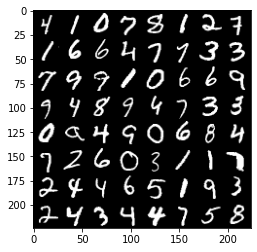

[[4 1 0 7 8 1 2 7]
 [1 6 6 4 7 7 3 3]
 [7 9 9 1 0 6 6 9]
 [9 4 8 9 4 7 3 3]
 [0 9 4 9 0 6 8 4]
 [7 2 6 0 3 1 1 7]
 [2 4 4 6 5 1 9 3]
 [2 4 3 4 4 7 5 8]]


In [50]:
import matplotlib.pyplot as plt
import numpy as np

img0 = image[:64].reshape(8,8,28,28)
print(img0.shape)
img0 = np.transpose(img0, axes=(0,2,1,3)).reshape(8*28, 8*28)
plt.imshow(img0, cmap="gray")
plt.show()
print(label[:64].reshape(8,8))

In [ ]:
image.shape, label.shape

((64, 28, 28, 1), (64,))

## Feladat: Kategorizáljuk a képeket
## Hogyan lehet ilyesmit leprogramozni?

Az első ötletünk az lehet, hogy próbáljuk megérteni, mitől érzékelünk egy képet 1-esnek, 2-esnek, stb. majd ezt valahogy formalizáljuk végül lekódoljuk.

Ez teljesen reménytelennek tűnik. Ehelyett inkább olyan eljárást keresünk, ami egy könnyen számolható függvény osztályból kiválaszt egyet, ami az esetek többségében jól működik. 

#### Milyen függvény osztályok jöhetnek szóba?

A függvény bemenete egy kép, jelen esetben szürkeárnyalatos 28x28 pixeles kép. Azaz minden bemenet 28x28 intenzitás értékkel van megadva. 
Erre gondolhatunk úgy, hogy egy 784 dimenziós (valós) vektorra. 


Mi lenne a függvény kimenete? 10 lehetséges kategória (osztály) között kell választani. Ezért a kimenet lehetne egy egész 0 és 9 között, de egyszerűbb 10 értéket kiszámolni és aztán a döntés a legnagyobb érték indexe.  

Azaz keresünk egy
$$
    g:\mathbb{R}^{784} \to \mathbb{R}^{10}, \quad f = \arg\max(g)
$$

A legegyszerűbb függvények a lineáris függvények, ezek könnyen paraméterezhetőek.

Általában is függvény osztály elemeit paraméteresen adjuk meg és a paramétereket szeretnénk azonosítani. 


## Paraméterek keresése, veszteség minimalizálás

Mikor gondolnánk egyik függvényt jobbnak mint a másikat? Nyilván akkor, ha több helyest döntést hoz. Azaz $g_0(x_i),\dots,g_9(x_i)$ értékek 
közül az esetek többségében az $y_i$ indexű a legnagyobb, ahol $(x_i,y_i)$ az ismert input-output párokat jelöli.

Egy lehetséges kritérium, hogy az $y_i$ indexet 0-1 vektorként kódoljuk $z_i=(\mathbb{1}_{k=y_i})_{k=0}^9$ és olyan $g$-t keresünk, amire
$$
    \sum_i \|g(x_i) - z_i\|^2 
$$
minimális.

Egy másik lehetőség lehetne, hogy a
$$
    \sum_i \sum_k (2z_{i,k}-1)*g_k(x_i)
$$
kifejezést próbálnánk maximalizálni. Ezzel az a gond, hogy felülről nem feltétlenül korlátos.

Egy további lehetőség lehetne, hogy a
$$
    \sum_i \sum_k \max(1-(2z_{i,k}-1)*g_k(x_i),0)
$$
minimalizálása, vagy
$$
    \sum_i -\log p_{y_i}(x_i), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_\ell e^{g_\ell(x)}}
$$
minimalizálása.

Ezekben az a közös, hogy megfogalmazhatóak egy ($x$-ben differenciálható) veszteség minimalizálásaként.


## Gradiens ereszkedés (Gradient descent)
Néhány esetben a megoldás kifejezhető az $(x_i, y_i)$ párok segítségével, de még ezekben az esetekben is inkább általános iterative eljárást szoktak használni. 

A $g(x)$ valójában $g(x,\vartheta)$, ahol $\vartheta$ a függvény megadására szolgáló paraméter vektor. pl. ha $g$ lineáris, akkor
$$
    g(x) = b + Ax,\quad \vartheta=(b, A),\quad b\in\mathbb{R}^{10},\quad A\in\mathbb{R}^{10\times 784}, \quad x\in\mathbb{R}^{784}
$$

Azaz $g$ a paraméter szerint is deriválható. Ha $\ell$ jelöli a veszteség függvényt, akkor
$$
    \hat\vartheta = \arg\min_{\theta}L(\vartheta), \quad L(\vartheta) = \frac1n\sum_{i} \ell (g(x_i,\vartheta), y_i)
$$
úgy is számolható, hogy
$$
    \vartheta_{n+1} = \vartheta_n -\eta L'(\vartheta_n)
$$
ahol $\eta$ általában egy kicsi szám, a tanulási ráta. Mindig abba az irányba próbáljuk $\vartheta_n$-t módosítani amerre a leginkább csökken.
Ezt a minimalizálási eljárást gradiens ereszkedésnek hívják.

Gyakran nem kell $L'$-t pontosan számolni elegendő az adatok egy $b$ részét használni, Azaz $L'$ helyett $L'_b$-t használjuk, ahol
$$
    L'_b(\vartheta)=\frac{1}{|b|}\sum_{i\in b} \partial_\vartheta\ell(g(x_i, \vartheta), y_i)
$$

Szerencsére a derivált számolást nem kell leprogramozni. A neurális hálós keretrendszerek mind megteszik ezt nekünk. Mi a `jax` könytárat fogjuk használni.



In [51]:
try:
    import jax
except ModuleNotFoundError:
    ! pip install jax[cpu]


In [52]:
from jax import grad
import jax.numpy as jnp

def tanh(x):  # Define a function
  y = jnp.exp(-2.0 * x)
  return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)  # Obtain its gradient function
print(grad_tanh(1.0))   # Evaluate it at x = 1.0
# prints 0.4199743

0.4199743


In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
def g(theta, x):
    x = x.reshape(-1)
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), np.random.normal(size=(10, 784))

In [ ]:
x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')

[ 3275.09830496   -37.21438548 -4913.04615196   265.17560735
    31.35366723  -303.69938944 -2099.60785345   353.98055454
  1598.43740666  5027.56065609]
A képen 9 van?


Szerencsésebb lenormálni az $A$ mátrixot, és a képet is.

In [ ]:
image[0].max()

255

In [ ]:
def g(theta, x):
    x = x.reshape(-1)/255
    b, A = theta
    return b + A @ x

def f(g):
    return g.argmax()

theta = np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))

[-1.49772025  0.6160644  -0.49144092 -0.60869463 -0.88787624  0.68045991
  1.17207926  0.0488065  -0.82755319 -0.37638879]
A képen 6 van?


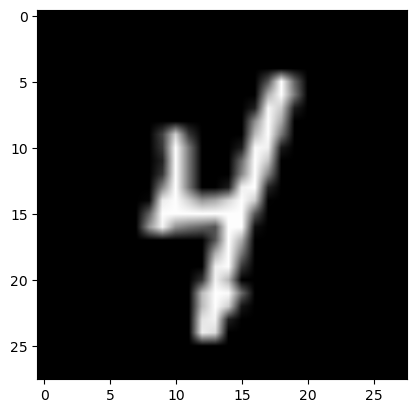

In [ ]:

x = image[0]
pred = g(theta, x)
print(f'{pred}\nA képen {f(pred)} van?')
plt.imshow(x, cmap='gray', interpolation='bilinear')

## Veszteség függvény

Válasszuk a keresztentrópiát:
$$
    \sum_i -\log p_{y_i}(x_i)=\sum -g_{y_i}(x_i)+\log(\sum_je^{g_j(x_i)}), \quad p_k(x)=\frac{e^{g_k(x)}}{\sum_j e^{g_j(x)}}
$$

In [ ]:
def ell(pred, y):
    return jax.nn.log_softmax(pred) @ y

def ell(pred, y):
    return -pred@y + jax.nn.logsumexp(pred)


In [ ]:
y = jax.nn.one_hot(label[0], 10)
pred = g(theta, x)
log_p = jax.nn.log_softmax(pred)
print(f'pred: \t{pred}\none-hot:\t{y}\nlog p:\t{log_p}\nloss:\t{ell(pred, y)}')

pred: 	[-1.49772025  0.6160644  -0.49144092 -0.60869463 -0.88787624  0.68045991
  1.17207926  0.0488065  -0.82755319 -0.37638879]
one-hot:	[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
log p:	[-3.8973916 -1.783607  -2.8911123 -3.008366  -3.2875476 -1.7192116
 -1.2275922 -2.350865  -3.2272246 -2.77606  ]
loss:	3.2875478267669678


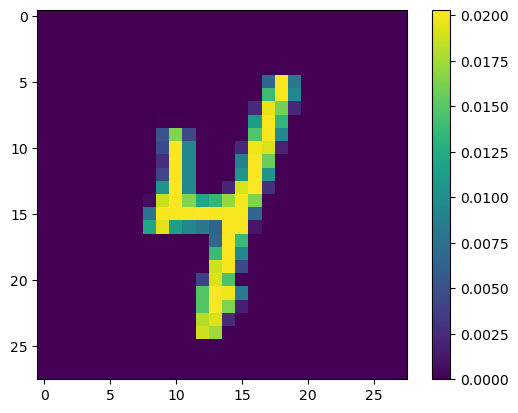

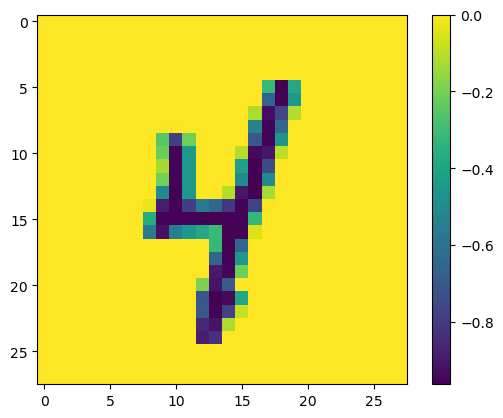

In [ ]:
def L(theta, x, y):
    pred = g(theta, x)
    return ell(pred, y)

dL = grad(L)

dx, dA = dL(theta, x, y)

plt.imshow(dA[0].reshape(28,28))
plt.colorbar()
plt.show()

plt.imshow(dA[4].reshape(28,28))
plt.colorbar()
plt.show()

In [ ]:
batch_L = jax.vmap(L, in_axes=None)
batch_L(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))


DeviceArray([3.4490073, 1.7385118, 3.7904572, 2.1432137, 2.6626916,
             1.739611 , 3.0971804, 2.1436489, 1.7388439, 1.2247502,
             1.2250168, 3.4521928, 2.142751 , 2.1438115, 3.108529 ,
             3.111162 ], dtype=float32)

In [ ]:
def loss_fn(theta, x, y):
    return batch_L(theta, x=x, y=y).mean(axis=0)

loss_fn = jax.value_and_grad(loss_fn)

def training_step(theta, x, y, eta):
    y = jax.nn.one_hot(y, 10)
    loss, gradient = loss_fn(theta, x=x, y=y)
    return loss, jax.tree_map(lambda t, g: t-eta*g, theta, gradient)

In [ ]:
# loss_fn(theta, x=image[:16]/255, y=jax.nn.one_hot(label[:16], 10))
loss, gradient = training_step(theta, x=image[:16], y=label[:16], eta=0.1)

In [ ]:
gradient

(DeviceArray([-1.5207002 ,  0.53177977, -0.8258966 , -0.8323443 ,
              -1.172576  ,  0.30743843,  1.0258439 ,  0.13698131,
              -0.38965613, -0.60936165], dtype=float32),
 DeviceArray([[ 0.00590924,  0.01492054,  0.05426774, ...,  0.03065958,
               -0.02883035, -0.00548899],
              [ 0.02282139, -0.02166771, -0.02342675, ...,  0.0187288 ,
                0.08606442,  0.00661989],
              [ 0.00715256,  0.0130913 ,  0.01443851, ..., -0.00874267,
                0.03696657,  0.02089454],
              ...,
              [ 0.00162779,  0.00478212, -0.05017671, ..., -0.04711561,
                0.0825582 , -0.0291477 ],
              [ 0.04426444,  0.01472315, -0.00354062, ..., -0.01670469,
               -0.00563352,  0.00841743],
              [ 0.01847646,  0.00811964, -0.0192298 , ..., -0.003944  ,
                0.07144068,  0.01361984]], dtype=float32))

In [ ]:
theta = theta = 0.1 * np.random.normal(size=10), (784**(-0.5))*np.random.normal(size=(10, 784))
eta = 0.1
losses = []

for i, example in tqdm(enumerate(train.repeat().shuffle(10000).batch(256).take(2000).as_numpy_iterator())):
    img, label = example['image'], example['label']
    loss, theta = training_step(theta, img, label, eta)
    losses.append(loss)
    if (i+1) % 200==0:
        eta *= 0.5

150it [00:02, 68.83it/s]2022-11-28 06:15:23.638258: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2000it [00:25, 78.84it/s]


In [ ]:
eta

9.765625e-05

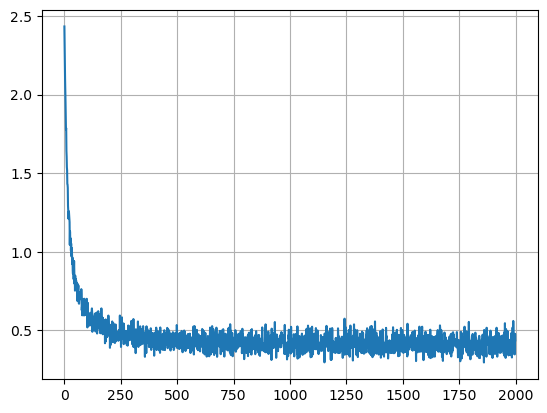

In [ ]:
plt.plot(losses)
plt.grid()
plt.show()

In [ ]:
def predict(theta, x):
    return jax.vmap(g, in_axes=None)(theta, x=x).argmax(axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm_(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    cm = pd.DataFrame(
        confusion_matrix(
            y_pred=y_pred, 
            y_true=y_true, 
            labels=classes
            ), 
            columns=classes, 
            index=classes)
    cm.index.name = 'True'
    cm.columns.name = 'Predicted'
    return cm


In [ ]:
preds = []
labels = []
for example in test.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('test tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)
#confusion_matrix(y_pred=preds, y_true=label, labels=range(10))

test tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,909,0,7,5,1,11,11,1,13,1
1,1,1089,7,7,0,7,0,3,14,1
2,9,13,862,11,24,2,20,26,30,2
3,8,4,23,891,1,34,4,12,24,16
4,2,11,10,1,900,2,10,1,7,43
5,20,11,9,40,19,721,19,7,48,18
6,6,5,14,2,13,15,926,0,7,0
7,8,20,15,1,19,0,0,961,2,31
8,7,34,21,38,10,23,9,6,805,20


In [ ]:
preds = []
labels = []
for example in train.batch(256).as_numpy_iterator():
    img, label = example['image'], example['label']
    preds.append(predict(theta, x=img))
    labels.append(label)
preds = np.concatenate(preds)
labels = np.concatenate(labels)
print('train tévesztési mátrix')
cm_(y_pred=preds, y_true=labels)


train tévesztési mátrix


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4747,0,24,18,12,38,56,7,56,6
1,0,5413,23,26,4,45,9,14,70,9
2,52,69,4215,94,111,13,114,98,154,39
3,31,44,138,4363,6,218,43,76,126,69
4,11,29,34,5,4384,4,63,13,44,268
5,91,69,37,218,83,3607,96,27,201,80
6,41,27,66,3,39,79,4617,2,54,2
7,47,84,82,24,71,10,3,4664,23,200
8,28,148,63,160,21,156,43,31,4130,98


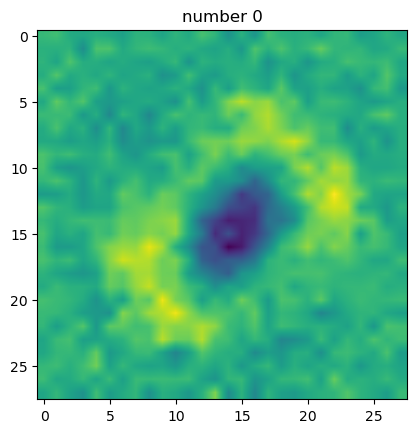

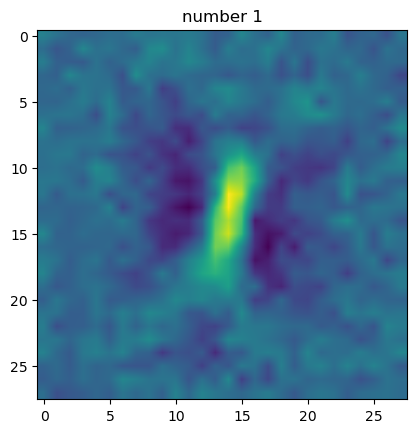

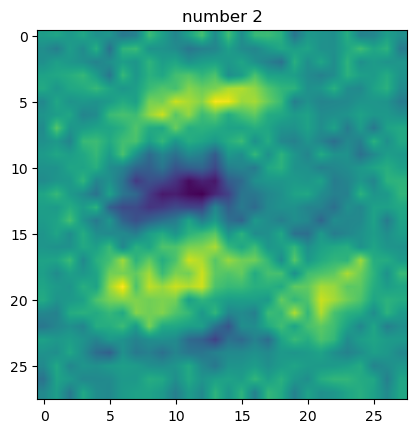

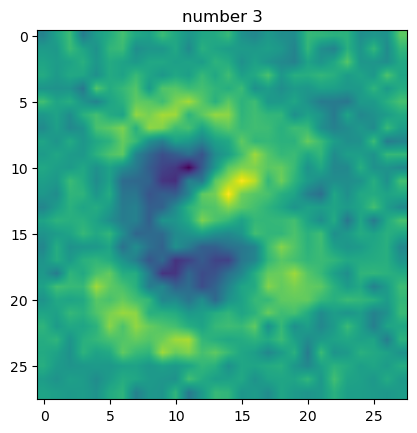

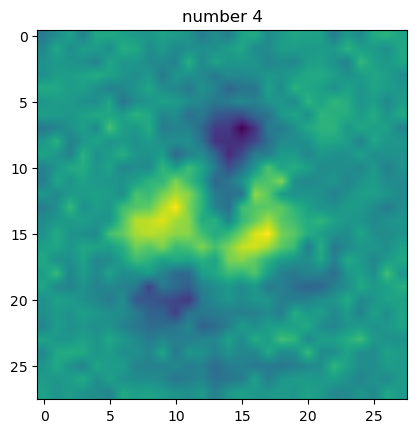

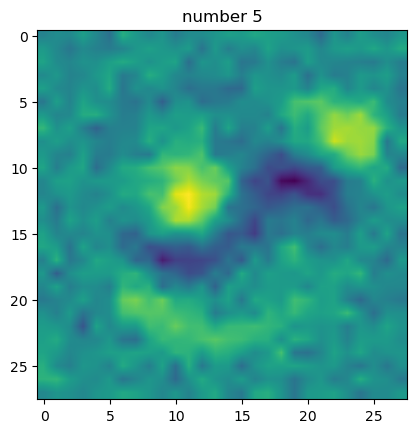

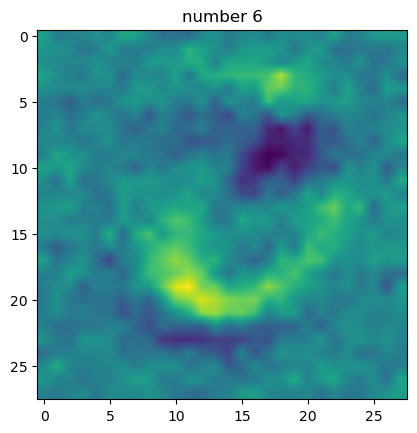

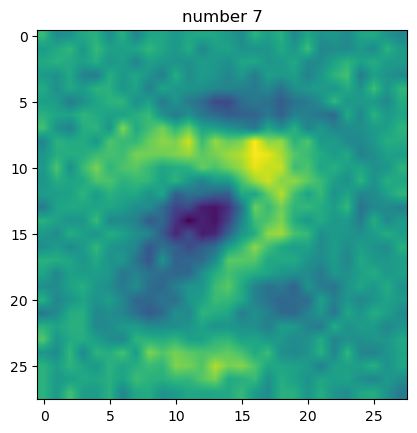

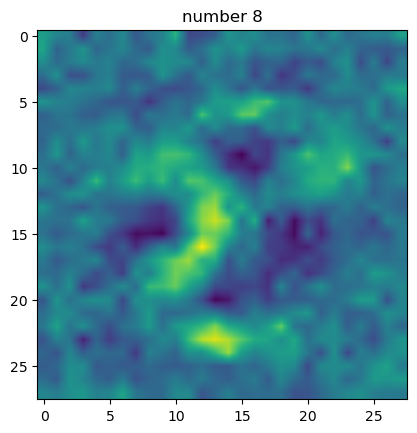

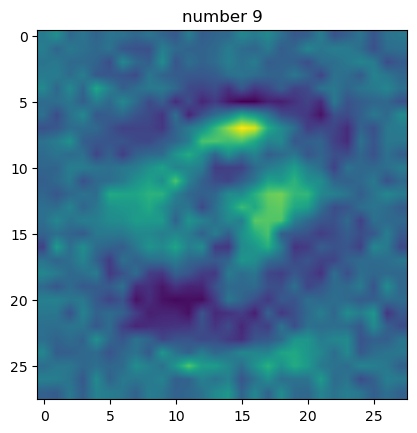

In [ ]:
b, A = theta
for i, row in enumerate(A):
    plt.imshow(row.reshape(28, 28), interpolation='bilinear')
    plt.title(f'number {i}')
    plt.show()

## Több rétegű neurális háló

Lineáris függvények családja nagyon szűk. 

Az derül ki, hogy ha $g_1\circ \sigma\circ g_2$ alakban már tetszőleges (folytonos) függvény közelíthető, ha a közepső tér dimenziója elég nagy és
$\sigma$ egy koordinátánként számolt nem lineáris **aktivációs** függvény. Szokásos választások $\sigma$-ra $\sigma(x)=\max(x,0)$,  vagy $\sigma(x)=\tanh(x)$, vagy $\sigma(x)=1/(1+e^{-x})$ (mindegyik koordinátánként értendő).

A következő rész a `jax` dokumentációjában szereplő példa.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/Neural_Network_and_Data_Loading.ipynb)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

A véletlen számokat a `jax` rendszer kicsit másképp kezeli. A véletlenszám generátornak mindig meg kell adni egy kulcsot (a generátor állapotát).
Új véletlenszám generálása előtt a kulcsot szét kell bontani, az egyikből az aktuális érték(ek)et szzámoljuk, a másikból a következőket.

In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
params = init_network_params(layer_sizes, random.PRNGKey(0))

A `predict` függvény hasonló a fentihez, de most minden (rejtett) réteg után alkalmazunk egy `relu` (rectified linear unit, igazából pozitív rész) nem linearitást, vagy aktivációs függvényt. 

In [ ]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image.flatten()/255.0
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

In [ ]:
# This works on single examples
preds = predict(params, image[0])
print(preds.shape)
print(preds)

(10,)
[-2.2953994 -2.2987492 -2.2974277 -2.318979  -2.3008723 -2.3090346
 -2.3071167 -2.3012722 -2.3021984 -2.2950432]


Ugyanúgy mint a lineáris esetben a `predict` függvény nem képes több képet egyszerre kezelni. 

In [ ]:
try:
  preds = predict(params, image[:10])
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


A `vmap` transzformáció most is segít.

In [ ]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, image[:8])
print(batched_preds.shape)

(8, 10)


In [ ]:
n_targets = 10

In [ ]:
def y_pred_true(f, params, dataset):
    y_pred = []
    y_true = []
    for example in tqdm(dataset.batch(256).as_numpy_iterator()):
        images, targets = example['image'], example['label']
        y_pred.append(f(params, images).argmax(axis=-1))
        y_true.append(targets)
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    return {'y_pred': y_pred, 'y_true':y_true}

def accuracy(f, params, dataset):
    y = y_pred_true(f, params, dataset)
    acc = sum(y['y_pred'] == y['y_true'])
    n = len(y['y_pred'])
    return acc/n

def loss(params, images, targets):
    targets = jax.nn.one_hot(targets, n_targets)
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)*n_targets

@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


Konstansok:

In [ ]:
step_size = 0.1
num_epochs = 8
batch_size = 128


In [ ]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(train.shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(batched_predict, params, train)
  test_acc = accuracy(batched_predict, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

391it [00:02, 194.71it/s]
196it [00:01, 99.23it/s] 
40it [00:00, 102.49it/s]


Epoch 0 in 2.04 sec
Training set accuracy 4312.4
Test set accuracy 864.2


391it [00:01, 249.10it/s]
196it [00:01, 98.98it/s] 
40it [00:00, 101.64it/s]


Epoch 1 in 1.59 sec
Training set accuracy 4563.7
Test set accuracy 913.5


391it [00:01, 243.16it/s]
196it [00:01, 100.81it/s]
40it [00:00, 100.77it/s]


Epoch 2 in 1.63 sec
Training set accuracy 4669.0
Test set accuracy 928.9


391it [00:01, 243.62it/s]
196it [00:02, 97.32it/s] 
40it [00:00, 98.02it/s]


Epoch 3 in 1.62 sec
Training set accuracy 4737.2
Test set accuracy 941.3


391it [00:01, 241.17it/s]
196it [00:01, 98.31it/s] 
40it [00:00, 98.24it/s]


Epoch 4 in 1.64 sec
Training set accuracy 4792.5
Test set accuracy 955.2


391it [00:01, 247.32it/s]
196it [00:01, 101.71it/s]
40it [00:00, 100.34it/s]


Epoch 5 in 1.60 sec
Training set accuracy 4832.7
Test set accuracy 959.6


391it [00:01, 250.90it/s]
196it [00:01, 100.93it/s]
40it [00:00, 101.51it/s]


Epoch 6 in 1.58 sec
Training set accuracy 4859.2
Test set accuracy 962.8


391it [00:01, 248.35it/s]
196it [00:01, 101.45it/s]
40it [00:00, 100.73it/s]

Epoch 7 in 1.59 sec
Training set accuracy 4874.2
Test set accuracy 967.7


In [ ]:
train_y = y_pred_true(batched_predict, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

196it [00:01, 101.95it/s]


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4869,0,6,2,1,5,10,2,5,5
1,1,5521,9,4,8,3,8,15,22,5
2,11,19,4848,36,7,4,3,30,8,0
3,5,16,28,4972,2,42,0,6,36,20
4,3,5,9,0,4685,5,10,17,7,33
5,9,1,2,28,2,4371,35,1,13,8
6,21,4,6,0,19,12,4848,0,7,1
7,3,6,18,13,3,2,0,5028,1,18
8,29,31,27,35,6,36,16,8,4735,15


In [ ]:
test_y = y_pred_true(batched_predict, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

40it [00:00, 98.97it/s]


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,935,1,1,1,1,4,3,1,1,1
1,0,1099,3,0,2,0,2,1,9,0
2,1,7,972,6,2,2,1,7,0,0
3,1,4,8,984,0,14,0,4,13,6
4,1,2,5,1,958,1,8,1,1,12
5,3,0,0,8,0,867,8,1,5,0
6,4,1,1,0,4,4,961,0,3,0
7,0,4,6,4,1,0,0,1021,1,5
8,10,9,2,6,1,6,5,0,930,5


## Konvolúciós háló

Az ötlet az, hogy a kép kis részeit tekintsük, pl. az összes 5*5-ös részképet és mindegyikre ugyanazt a lineáris leképezést alkalmazzuk, majd az eredményekre az aktivációs függvényt. Ezzel kapunk egy másik (gyakran kisebb) képet ahol, nem 1 vagy 3 ,,szín'' van, hanem sok, attól függően, hogy hány ismérvet számolunk ki a kis képből. Ezzel a kép lokális tulajdonságait lehet kigyűjteni (van vonal vagy nincs, annak az iránya stb). Ilyen rétegeket pakolunk egymásra és a végén a kapott képre az imént látott összegzést alkalmazzuk.
 


In [ ]:
try:
    import haiku as hk
except ModuleNotFoundError:
    ! pip install dm-haiku

In [ ]:
hk.MaxPool?

Init signature: hk.MaxPool(*args, **kwargs) -> ~T
Docstring:     
Max pool.

Equivalent to partial application of :func:`max_pool`.
Init docstring:
Max pool.

Args:
  window_shape: Shape of window to pool over. Same rank as value or ``int``.
  strides: Strides for the window. Same rank as value or ``int``.
  padding: Padding algorithm. Either ``VALID`` or ``SAME``.
  channel_axis: Axis of the spatial channels for which pooling is skipped.
  name: String name for the module.
File:           ~/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/haiku/_src/pool.py
Type:           ModuleMetaclass
Subclasses:     


In [ ]:
hk.transform?

Signature: hk.transform(f, *, apply_rng=True) -> haiku._src.transform.Transformed
Docstring:
Transforms a function using Haiku modules into a pair of pure functions.

For a function ``out = f(*a, **k)`` this function returns a pair of two pure
functions that call ``f(*a, **k)`` explicitly collecting and injecting
parameter values::

    params = init(rng, *a, **k)
    out = apply(params, rng, *a, **k)

Note that the ``rng`` argument is typically not required for ``apply`` and
passing ``None`` is accepted.

The first thing to do is to define a :class:`Module`. A module encapsulates
some parameters and a computation on those parameters:

>>> class MyModule(hk.Module):
...   def __call__(self, x):
...     w = hk.get_parameter("w", [], init=jnp.zeros)
...     return x + w

Next, define some function that creates and applies modules. We use
:func:`transform` to transform that function into a pair of functions that
allow us to lift all the parameters out of the function (``f.init``) and
appl

In [ ]:
def lenet(x):
    x = x.astype(jnp.float32)/255
    x = hk.Conv2D(32, 5, padding='VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    #x = hk.Conv2D(64, 5, 'VALID')(x)
    x = jax.nn.relu(x)
    x = hk.MaxPool(2, 2, padding='VALID')(x)
    x = hk.Flatten()(x)
    x = hk.Linear(128)(x)
    x = jax.nn.relu(x)
    x = hk.Linear(n_targets)(x)
    x = jax.nn.log_softmax(x)
    return x


In [ ]:
param_init, lenet_apply = hk.transform(lenet)
def lenet_fn(params, images):
    return lenet_apply(params, None, images)

In [ ]:
key = jax.random.PRNGKey(0)
params = param_init(key, image[:10])

In [ ]:
lenet_apply(params, None, image[:1])

DeviceArray([[-2.2921522, -2.4065294, -2.1999078, -2.1794224, -2.448887 ,
              -2.2928278, -2.1351295, -2.393769 , -2.602898 , -2.1719048]],            dtype=float32)

In [ ]:

def lenet_loss(params, images, targets):
  targets = jax.nn.one_hot(targets, n_targets)
  preds = lenet_apply(params, None, images)
  return -jnp.mean(preds * targets)*n_targets

@jit
def lenet_update(params, x, y):
  grads = grad(lenet_loss)(params, x, y)
  return jax.tree_map(lambda p, g: p - step_size * g, params, grads)


In [ ]:
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for example in tqdm(ds.cache().shuffle(5000).batch(128).as_numpy_iterator()):
    x, y = example['image'], example['label']
    params = lenet_update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(lenet_fn, params, train)
  test_acc = accuracy(lenet_fn, params, test)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

469it [00:29, 16.09it/s]
196it [00:07, 27.31it/s]
40it [00:01, 25.54it/s]


Epoch 0 in 29.17 sec
Training set accuracy 0.96476
Test set accuracy 0.9655


469it [00:28, 16.56it/s]
196it [00:06, 29.48it/s]
40it [00:01, 31.35it/s]


Epoch 1 in 28.36 sec
Training set accuracy 0.97516
Test set accuracy 0.9763


469it [00:27, 17.15it/s]
196it [00:06, 29.95it/s]
40it [00:01, 31.00it/s]


Epoch 2 in 27.37 sec
Training set accuracy 0.98284
Test set accuracy 0.9838


469it [00:28, 16.72it/s]
196it [00:06, 30.27it/s]
40it [00:01, 30.91it/s]


Epoch 3 in 28.07 sec
Training set accuracy 0.9867
Test set accuracy 0.988


469it [00:27, 17.16it/s]
196it [00:06, 30.20it/s]
40it [00:01, 30.82it/s]


Epoch 4 in 27.37 sec
Training set accuracy 0.98832
Test set accuracy 0.9899


469it [00:27, 17.12it/s]
196it [00:06, 30.16it/s]
40it [00:01, 30.61it/s]


Epoch 5 in 27.42 sec
Training set accuracy 0.98992
Test set accuracy 0.9905


469it [00:27, 17.22it/s]
196it [00:06, 30.41it/s]
40it [00:01, 31.18it/s]


Epoch 6 in 27.26 sec
Training set accuracy 0.98978
Test set accuracy 0.9923


469it [00:27, 17.13it/s]
196it [00:05, 33.53it/s]
40it [00:01, 30.77it/s]

Epoch 7 in 27.40 sec
Training set accuracy 0.98902
Test set accuracy 0.9913


In [ ]:
train_y = y_pred_true(lenet_fn, params, train)
cm_(train_y['y_pred'], train_y['y_true'])

196it [00:06, 30.46it/s]


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,4961,1,18,12,4,11,30,6,7,15
1,0,5596,4,3,6,3,3,9,1,3
2,0,6,4900,15,0,1,1,15,3,0
3,0,0,1,5010,0,14,0,0,2,0
4,0,0,4,0,4813,1,3,6,2,13
5,0,0,0,8,0,4391,0,0,1,2
6,1,1,1,1,2,14,4877,0,1,0
7,0,7,7,10,2,0,0,5147,0,13
8,1,2,20,46,8,63,16,9,4854,22


In [ ]:
test_y = y_pred_true(lenet_fn, params, test)
cm_(test_y['y_pred'], test_y['y_true'])

40it [00:01, 30.47it/s]


Predicted,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,958,1,2,0,1,5,2,1,1,2
1,0,1120,4,0,1,0,0,1,1,0
2,0,4,985,3,0,0,0,0,1,0
3,0,0,0,1005,0,1,0,1,0,0
4,0,1,0,0,981,0,1,0,0,0
5,0,0,0,1,0,893,1,0,0,0
6,0,0,0,0,1,1,978,0,0,0
7,0,3,3,0,0,0,0,1052,1,2
8,1,0,4,7,1,9,6,0,967,1
